# > Initial setting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# > Load data and preprocessing

## >> Skills

In [65]:
df1 = pd.read_excel("datasets/skills.xlsx")

In [125]:
# select relevant columns
skills_raw = df1.copy()
skills_raw = skills_raw.iloc[:, [1, 3, 5, 6, 12, 15]]  # adjust column indices if needed

skills = skills_raw.copy()

# unpivot the element name to have two columns
skills = skills.pivot_table(
    index=["Title", "Element Name"],
    columns="Scale Name",
    values="Data Value"
).reset_index()

# merge Not Relevant and Category back
nr = df1[df1['Scale Name']=='Level'][['Title','Element Name','Not Relevant','Category']]
skills = skills.merge(nr, on=['Title','Element Name'], how='left')

# add score as average of Importance and Level
skills['score'] = skills[['Importance', 'Level']].mean(axis=1)

# filter only relevant skills
skills = skills[skills['Not Relevant'] != "Y"]

# separate soft and tech skills
soft_df = skills[skills['Category'] == 'soft'][['Title', 'Element Name', 'score']].rename(
    columns={'Title': 'title', 'Element Name': 'soft_skill', 'score': 'soft_score'}
)

tech_df = skills[skills['Category'] == 'tech'][['Title', 'Element Name', 'score']].rename(
    columns={'Title': 'title', 'Element Name': 'tech_skill', 'score': 'tech_score'}
)

print(soft_df.head())
print(tech_df.head())

                      title               soft_skill  soft_score
0  Accountants and Auditors          Active Learning       3.310
1  Accountants and Auditors         Active Listening       3.815
2  Accountants and Auditors  Complex Problem Solving       3.440
3  Accountants and Auditors             Coordination       3.250
4  Accountants and Auditors        Critical Thinking       3.935
                       title                tech_skill  tech_score
14  Accountants and Auditors               Mathematics       3.500
18  Accountants and Auditors       Operations Analysis       1.250
19  Accountants and Auditors     Operations Monitoring       1.565
21  Accountants and Auditors               Programming       1.875
22  Accountants and Auditors  Quality Control Analysis       1.500


In [126]:
# aggregate for each Title for soft skills
soft = soft_df.groupby('title')['soft_score'].mean().reset_index()
print(soft.head())

print(f"Total job roles: {soft.shape[0]}")

                      title  soft_score
0  Accountants and Auditors    3.234750
1                    Actors    2.983056
2                 Actuaries    3.440750
3            Acupuncturists    2.984500
4         Acute Care Nurses    3.643250
Total job roles: 894


In [127]:
# aggregate for each Title for tech skills
tech = tech_df.groupby('title')['tech_score'].mean().reset_index()
print(tech.head())

print(f"Total job roles: {tech.shape[0]}")

                      title  tech_score
0  Accountants and Auditors    2.133750
1                    Actors    1.546250
2                 Actuaries    2.818889
3            Acupuncturists    1.637727
4         Acute Care Nurses    2.416250
Total job roles: 894


In [128]:
# summary of tech skills
print("Soft Skills Summary:")
print(soft['soft_score'].describe())
print("Tech Skills Summary:")   
print(tech['tech_score'].describe())   

Soft Skills Summary:
count    894.000000
mean       2.994133
std        0.481233
min        1.749474
25%        2.595687
50%        3.004875
75%        3.419000
max        4.331500
Name: soft_score, dtype: float64
Tech Skills Summary:
count    894.000000
mean       2.180541
std        0.419605
min        0.970000
25%        1.855932
50%        2.169712
75%        2.468554
max        3.604000
Name: tech_score, dtype: float64


## >> AI Labor Index

In [129]:
df2 = pd.read_excel("datasets/ali.xlsx")

In [130]:
ali = df2.copy()
ali = ali.iloc[:,  [0, 1, 4, 6, 3]]
ali.head()

,task,suboccupation,llm_ai,software,automation
0,"Bill customers for repair work, and collect pa...",Home Appliance Repairers,0,5,5
1,Compare instrument pitches with tuning tool pi...,Musical Instrument Repairers and Tuners,0,5,5
2,Order parts needed for machine repairs.,"Coin, Vending, and Amusement Machine Servicers...",0,5,5
3,Maintain records of machine maintenance and re...,"Coin, Vending, and Amusement Machine Servicers...",2,5,5
4,Keep records of employees' attendance and hour...,First-Line Supervisors of Production and Opera...,0,5,5


In [131]:
# aggregate by suboccupation with average of llm_ai, software, and automation columns
ali = (
    ali.groupby("suboccupation")
    .agg(
        llm_ai=("llm_ai", "mean"),
        software=("software", "mean"),
        automation=("automation", "mean")
    )
    .reset_index()
)
print(ali.head())
print(f"Total job roles: {ali.shape[0]}")

              suboccupation    llm_ai  software  automation
0  Accountants and Auditors  2.965517  3.758621    3.344828
1                    Actors  1.722222  0.888889    1.722222
2                 Actuaries  2.666667  2.866667    2.800000
3            Acupuncturists  2.000000  2.111111    2.611111
4         Acute Care Nurses  2.120000  1.920000    2.400000
Total job roles: 923


## >> Merge dataset

In [132]:
# merge between ali, soft, and tech skills
df = soft
df = df.merge(tech, on="title", how="inner")
df = df.merge(ali, left_on="title", right_on="suboccupation", how="inner")
df.head()

,title,soft_score,tech_score,suboccupation,llm_ai,software,automation
0,Accountants and Auditors,3.234750,2.133750,Accountants and Auditors,2.965517,3.758621,3.344828
1,Actors,2.983056,1.546250,Actors,1.722222,0.888889,1.722222
2,Actuaries,3.440750,2.818889,Actuaries,2.666667,2.866667,2.800000
3,Acupuncturists,2.984500,1.637727,Acupuncturists,2.000000,2.111111,2.611111
4,Acute Care Nurses,3.643250,2.416250,Acute Care Nurses,2.120000,1.920000,2.400000


In [133]:
print(f"Total job roles: {df.shape[0]}")

Total job roles: 894


In [134]:
# check NA values
print(df.isna().sum())

title            0
soft_score       0
tech_score       0
suboccupation    0
llm_ai           0
software         0
automation       0
dtype: int64


# > Regression

## >> Split

In [193]:
from sklearn.model_selection import train_test_split

# Define target and features
df['ai_index'] = df[['llm_ai', 'software', 'automation']].mean(axis=1)

y = df[['soft_score']]
X = df[['llm_ai', 'software', 'automation']]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=15
)

## >> Recipe

In [194]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

# Preprocessing steps
preprocessor = Pipeline([
    ('scaler', StandardScaler()),
    ('nzv', VarianceThreshold(threshold=1e-4))
])

# OLS, Ridge, Lasso, and Elastic Net Pipelines
ols = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', LinearRegression())
])

ridge = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', RidgeCV(alphas=np.logspace(-3, 3, 50), cv=10))
])

lasso = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', LassoCV(alphas=np.logspace(-3, 3, 50), cv=10, max_iter=5000))
])

elastic = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', ElasticNetCV(
        alphas=np.logspace(-3, 3, 50),
        l1_ratio=[.1, .5, .9],
        cv=10,
        max_iter=5000
    ))
])

## >> Model Fit

In [195]:
from sklearn.metrics import mean_squared_error

models = {
    "OLS": ols,
    "Ridge": ridge,
    "Lasso": lasso,
    "ElasticNet": elastic
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train.values.ravel())
    
    train_r2 = model.score(X_train, y_train)
    test_r2 = model.score(X_test, y_test)
    
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    reg = model.named_steps['regressor']
    
    results.append({
        "Model": name,
        "Alpha": getattr(reg, 'alpha_', np.nan),
        "L1 Ratio": getattr(reg, 'l1_ratio_', np.nan),
        "Train R²": train_r2,
        "Test R²": test_r2,
        "Test MSE": mse
    })

comparison_df = pd.DataFrame(results).round(4)
print(comparison_df)

        Model   Alpha  L1 Ratio  Train R²  Test R²  Test MSE
0         OLS     NaN       NaN    0.7270   0.7609    0.0577
1       Ridge  8.2864       NaN    0.7269   0.7605    0.0578
2       Lasso  0.0010       NaN    0.7270   0.7611    0.0577
3  ElasticNet  0.0041       0.1    0.7270   0.7609    0.0577


In [196]:
ols.fit(X, y)

coef = ols.named_steps['regressor'].coef_.ravel()

coef_df = pd.DataFrame({
    'skill_type': X.columns,
    'standardized_coefficient': coef
}).sort_values(by='standardized_coefficient', ascending=False)

print(coef_df)

   skill_type  standardized_coefficient
0      llm_ai                  0.292265
1    software                  0.134258
2  automation                 -0.189239


In [197]:
# Fit final model on full data
ols.fit(X, y.values.ravel())

# Predict AI exposure
df['ai_index_pred'] = ols.predict(X)

# Inspect HR roles
hr_managers = [
    'Compensation and Benefits Managers',
    'Training and Development Managers',
    'Human Resources Managers'
]

hr_roles = df[df['title'].isin(hr_managers)][
    ['title', 'soft_score', 'tech_score', 'ai_index', 'ai_index_pred']
]

hr_roles

,title,soft_score,tech_score,ai_index,ai_index_pred
154,Compensation and Benefits Managers,3.50550,2.188125,2.863636,3.354378
430,Human Resources Managers,3.96225,2.076667,2.961538,3.468279
849,Training and Development Managers,3.83750,2.175000,3.166667,3.501330


## >> Check for OLS result and VIF

In [198]:
import statsmodels.api as sm
feature_names = ols.named_steps['preprocess'].get_feature_names_out()
X_baked = pd.DataFrame(
    ols.named_steps['preprocess'].transform(X_train),
    columns=feature_names,
    index=X_train.index
)
X_with_const = sm.add_constant(X_baked)

ols_model = sm.OLS(y_train, X_with_const).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:             soft_score   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     551.2
Date:                Wed, 31 Dec 2025   Prob (F-statistic):          1.44e-174
Time:                        01:48:18   Log-Likelihood:                -16.255
No. Observations:                 625   AIC:                             40.51
Df Residuals:                     621   BIC:                             58.26
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0020      0.010    301.005      0.0

In [189]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Check for multicollinearity using VIF
vif_df = pd.DataFrame()
vif_df['feature'] = X_baked.columns
vif_df['VIF'] = [variance_inflation_factor(X_baked.values, i) for i in range(X_baked.shape[1])]
vif_df = vif_df.sort_values(by='VIF', ascending=False).reset_index(drop=True)
print(vif_df)

      feature      VIF
0    ai_index  1.00333
1  tech_score  1.00333


/Users/macbook/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


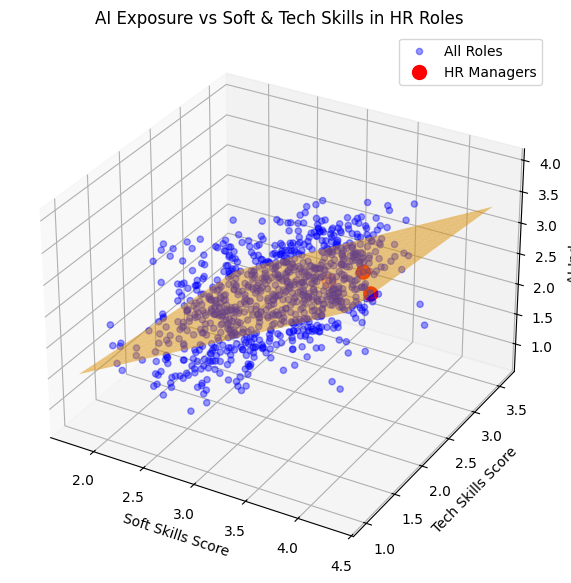

In [142]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Data
X_soft = df['soft_score'].values
X_tech = df['tech_score'].values
y_ai = df['ai_index'].values

# Mask for HR managers
hr_mask = df['title'].isin(hr_managers)
X_soft_hr = df.loc[hr_mask, 'soft_score'].values
X_tech_hr = df.loc[hr_mask, 'tech_score'].values
y_ai_hr = df.loc[hr_mask, 'ai_index'].values

# Create 3D figure
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for all roles
ax.scatter(X_soft, X_tech, y_ai, color='blue', alpha=0.4, label='All Roles')

# Scatter plot for HR managers
ax.scatter(X_soft_hr, X_tech_hr, y_ai_hr, color='red', s=100, label='HR Managers')

# Create grid for regression plane
soft_grid, tech_grid = np.meshgrid(
    np.linspace(X_soft.min(), X_soft.max(), 20),
    np.linspace(X_tech.min(), X_tech.max(), 20)
)

# Predicted AI index from OLS
ai_pred_grid = ols.predict(
    np.column_stack([
        soft_grid.ravel(),  # soft_score
        tech_grid.ravel()   # tech_score
    ])
).reshape(soft_grid.shape)

# Plot regression plane
ax.plot_surface(soft_grid, tech_grid, ai_pred_grid, color='orange', alpha=0.5)

# Labels
ax.set_xlabel('Soft Skills Score')
ax.set_ylabel('Tech Skills Score')
ax.set_zlabel('AI Index')
ax.set_title('AI Exposure vs Soft & Tech Skills in HR Roles')
ax.legend()

plt.show()

# > Extract Skills List

In [146]:
skills.head()

,Title,Element Name,Importance,Level,Not Relevant,Category,score
0,Accountants and Auditors,Active Learning,3.12,3.50,N,soft,3.310
1,Accountants and Auditors,Active Listening,3.75,3.88,N,soft,3.815
2,Accountants and Auditors,Complex Problem Solving,3.38,3.50,N,soft,3.440
3,Accountants and Auditors,Coordination,3.25,3.25,N,soft,3.250
4,Accountants and Auditors,Critical Thinking,3.75,4.12,N,soft,3.935


## >> Soft Skills

In [155]:
# Soft Skills
soft_hr = skills[
    (skills['Title'].isin(hr_managers)) &
    (skills['Category'] == 'soft')
]

soft_df_list = []
for title in hr_managers:
    subset = soft_hr[soft_hr['Title'] == title].sort_values(by='score', ascending=False)
    temp_df = pd.DataFrame({
        'Title': title,
        'Soft Skill': subset['Element Name'].values,
        'Soft Score': subset['score'].values
    })
    soft_df_list.append(temp_df)

soft_skills_df = pd.concat(soft_df_list, ignore_index=True)
soft_skills_df = soft_skills_df.sort_values(by=['Title', 'Soft Score'], ascending=[True, False]).reset_index(drop=True)

# Display results
print("Soft Skills DataFrame:")
display(soft_skills_df)

Soft Skills DataFrame:


,Title,Soft Skill,Soft Score
0,Compensation and Benefits Managers,Writing,4.060
1,Compensation and Benefits Managers,Speaking,4.060
2,Compensation and Benefits Managers,Reading Comprehension,4.060
3,Compensation and Benefits Managers,Active Listening,4.060
4,Compensation and Benefits Managers,Judgment and Decision Making,3.940
5,Compensation and Benefits Managers,Critical Thinking,3.940
6,Compensation and Benefits Managers,Active Learning,3.875
7,Compensation and Benefits Managers,Social Perceptiveness,3.690
8,Compensation and Benefits Managers,Time Management,3.685
9,Compensation and Benefits Managers,Management of Personnel Resources,3.685


## >> Tech Skills

In [ ]:
# Tech Skills
soft_hr = skills[
    (skills['Title'].isin(hr_managers)) &
    (skills['Category'] == 'tech')
]

soft_df_list = []
for title in hr_managers:
    subset = soft_hr[soft_hr['Title'] == title].sort_values(by='score', ascending=False)
    temp_df = pd.DataFrame({
        'Title': title,
        'Tech Skill': subset['Element Name'].values,
        'Tech Score': subset['score'].values
    })
    soft_df_list.append(temp_df)

tech_skills_df = pd.concat(soft_df_list, ignore_index=True)
tech_skills_df = tech_skills_df.sort_values(by=['Title', 'Tech Score'], ascending=[True, False]).reset_index(drop=True)

# Display results
print("Tech Skills DataFrame:")
display(tech_skills_df)

Tech Skills DataFrame:


,Title,Tech Skill,Tech Score
0,Compensation and Benefits Managers,Systems Evaluation,3.565
1,Compensation and Benefits Managers,Systems Analysis,3.500
2,Compensation and Benefits Managers,Mathematics,3.060
3,Compensation and Benefits Managers,Operations Analysis,2.815
4,Compensation and Benefits Managers,Programming,1.315
5,Compensation and Benefits Managers,Quality Control Analysis,1.190
6,Compensation and Benefits Managers,Technology Design,1.060
7,Compensation and Benefits Managers,Operations Monitoring,1.000
8,Human Resources Managers,Systems Evaluation,3.940
9,Human Resources Managers,Systems Analysis,3.435


## >> Evaluation

In [158]:
# Count non-zero coefficients
non_zero_count = np.sum(ols.named_steps['regressor'].coef_ != 0)

print("Non-zero coefficients:", non_zero_count)

Non-zero coefficients: 2


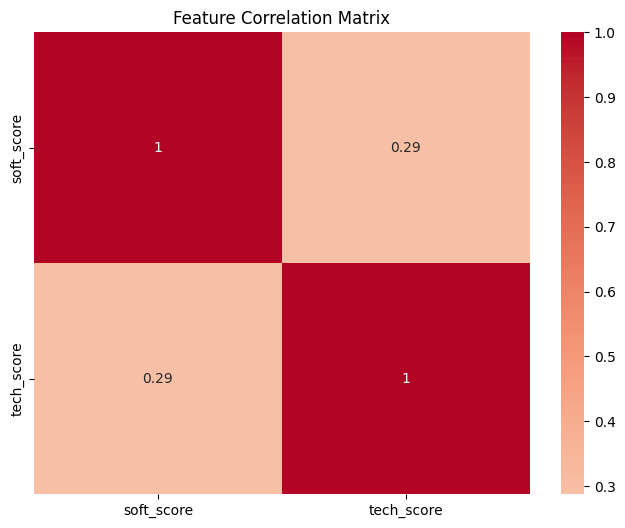

In [159]:
%matplotlib inline

# Plot correlation matrix
corr = X_baked.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

# > Classification and Ranking

In [164]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, roc_auc_score
import xgboost as xgb

# Create binary target: high AI automation potential (top 30% automation score)
df['high_ai_potential'] = (df['automation'] >= df['automation'].quantile(0.7)).astype(int)

# Focus on HR-relevant features
X = df[['soft_score', 'tech_score', 'llm_ai', 'software']]
y = df['high_ai_potential']

# HR managers as holdout test set
hr_mask = df['title'].isin(hr_managers)
X_train, y_train = X[~hr_mask], y[~hr_mask]
X_hr_test, y_hr_test = X[hr_mask], y[hr_mask]

# XGBoost with skill importance
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Feature importance for HR skills
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)
print("Skill Importance for High AI Potential:")
print(importance_df)

Skill Importance for High AI Potential:
      feature  importance
3    software    0.464020
0  soft_score    0.279058
2      llm_ai    0.160106
1  tech_score    0.096816


# > Unsupervised Clustering

In [171]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import pandas as pd

# Cluster occupations by skill+AI profiles
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# FIXED: Create DataFrame for plotly
plot_data = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'cluster': df['cluster'],
    'title': df['title'],
    'automation': df['automation'],
    'soft_score': df['soft_score'],
    'tech_score': df['tech_score']
})

# Visualize clusters
fig = px.scatter(plot_data, 
                 x='PC1', y='PC2', 
                 color='cluster',
                 hover_data=['title', 'automation', 'soft_score', 'tech_score'],
                 title="Occupation Clusters by Skills + AI Exposure",
                 color_continuous_scale='viridis')
fig.show()

# HR manager cluster analysis
hr_cluster_stats = df[df['title'].isin(hr_managers)].groupby('cluster').agg({
    'automation': 'mean',
    'soft_score': 'mean', 
    'tech_score': 'mean',
    'title': 'count'
}).round(3).rename(columns={'title': 'HR_count'})
print("HR Managers by Cluster:")
print(hr_cluster_stats)


HR Managers by Cluster:
         automation  soft_score  tech_score  HR_count
cluster                                              
2             2.934       3.768       2.147         3


In [180]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Cluster ALL occupations
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=4, random_state=42)
df_flag['cluster'] = kmeans.fit_predict(X_scaled)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plot_data = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'cluster': df_flag['cluster'],
    'title': df_flag['title'],
    'automation': df_flag['automation'],
    'soft_score': df_flag['soft_score'],
    'tech_score': df_flag['tech_score'],
    'is_hr_manager': df_flag['is_hr_manager']
})

# Calculate cluster centroids (average lines)
cluster_centroids = plot_data.groupby('cluster')[['PC1', 'PC2']].mean().reset_index()

# Base scatter plot - GRAY points + RED HR
fig = px.scatter(plot_data, 
                 x='PC1', y='PC2', 
                 color='is_hr_manager',
                 color_discrete_map={False: 'lightgray', True: '#e74c3c'},
                 size='automation',
                 hover_data=['title', 'cluster', 'soft_score', 'tech_score'],
                 title="All Occupations: HR Managers (Red) + Cluster Centers",
                 labels={'is_hr_manager': ''},
                 size_max=12)

fig.update_traces(marker=dict(line=dict(width=0.5, color='white')))

# Add cluster center lines (black diamonds)
for cluster_id in sorted(cluster_centroids['cluster']):
    centroid = cluster_centroids[cluster_centroids['cluster'] == cluster_id]
    
    # Cluster center point
    fig.add_trace(go.Scatter(
        x=centroid['PC1'], y=centroid['PC2'],
        mode='markers+text',
        marker=dict(size=18, symbol='diamond', color='black', line=dict(width=2, color='white')),
        text=[f'C{cluster_id}'],
        textposition="middle center",
        textfont=dict(size=12, color='white'),
        name=f'Cluster {cluster_id}',
        showlegend=True,
        hovertemplate=f'<b>Cluster {cluster_id} Center</b><extra></extra>'
    ))

# Clean layout
fig.update_layout(
    legend=dict(title="HR Manager", x=0.02, y=0.98),
    annotations=[
        dict(text="Red = HR-related roles | ◆ Black diamonds = cluster centers", 
             x=0.01, y=0.02, xref="paper", yref="paper", showarrow=False,
             font=dict(size=11), bgcolor="rgba(255,255,255,0.9)")
    ],
    showlegend=True,
    width=800, height=600
)

fig.show()

# HR positioning in clusters
hr_in_clusters = df_flag[df_flag['is_hr_manager']].groupby('cluster').agg({
    'title': ['count', lambda x: ', '.join(x.unique())],
    'automation': 'mean',
    'soft_score': 'mean',
    'tech_score': 'mean'
}).round(3)
hr_in_clusters.columns = ['HR_count', 'HR_roles', 'automation', 'soft_score', 'tech_score']
print("\nHR Managers Position in Clusters:")
print(hr_in_clusters)

# Cluster summary
cluster_summary = df_flag.groupby('cluster').agg({
    'title': 'count',
    'automation': 'mean',
    'soft_score': 'mean',
    'tech_score': 'mean'
}).round(3).rename(columns={'Title': 'total_jobs'})
print("\nCluster Summary (All Jobs):")
print(cluster_summary)



HR Managers Position in Clusters:
         HR_count                                           HR_roles  \
cluster                                                                
2               3  Compensation and Benefits Managers, Human Reso...   

         automation  soft_score  tech_score  
cluster                                      
2             2.934       3.768       2.147  

Cluster Summary (All Jobs):
         title  automation  soft_score  tech_score
cluster                                           
0          260       3.063       3.085       1.816
1          161       2.919       2.379       1.857
2          308       2.933       3.422       2.489
3          165       3.030       2.652       2.496


- Showing where HR managers sit in the occupational landscape
- Providing a macro narrative:
    - “Despite increasing AI exposure, HR roles cluster closer to soft-skill-intensive jobs”
- Motivating why skill analysis is needed